In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

/Users/rachel/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
end = datetime.now()
start = '2020-01-01'
df = yf.download('AAPL', start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


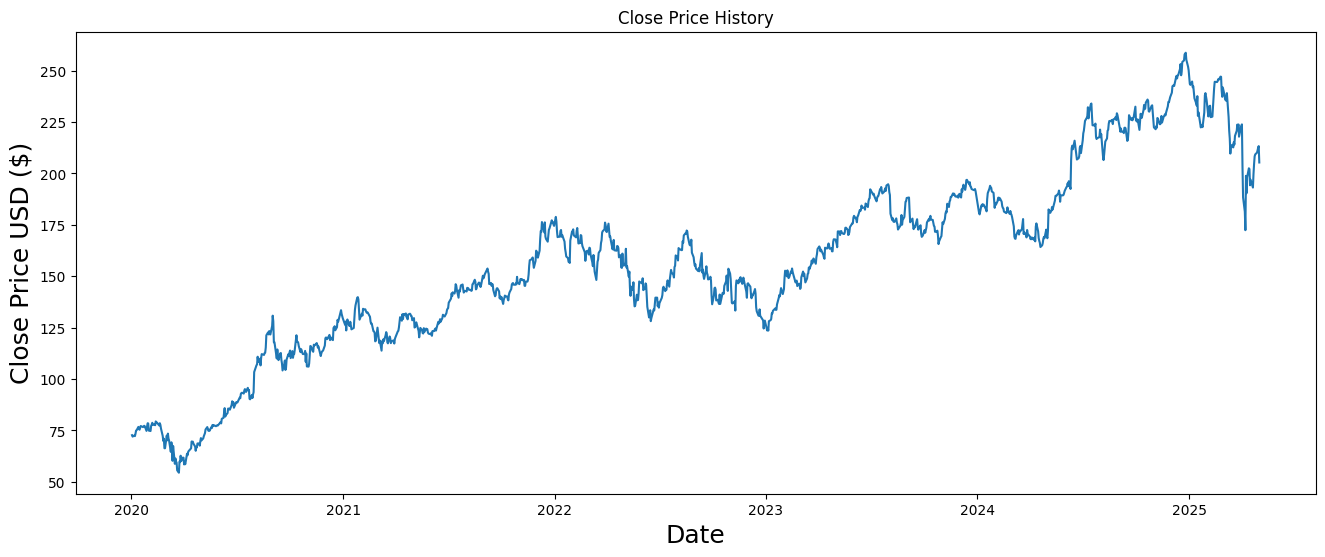

In [5]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()
# plt.savefig("close_price.png")  

In [6]:
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [7]:
data = df['Close']['AAPL']
dataset = data.values
dataset = data.values.reshape(-1, 1)

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

In [8]:
data.head()

Date
2020-01-02    72.716080
2020-01-03    72.009102
2020-01-06    72.582893
2020-01-07    72.241554
2020-01-08    73.403648
Name: AAPL, dtype: float64

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




[array([0.08941496, 0.08595423, 0.088763  , 0.0870921 , 0.09278068,
       0.10041289, 0.10124244, 0.10909996, 0.10402753, 0.10243947,
       0.10706146, 0.1111975 , 0.10863761, 0.1099769 , 0.11179015,
       0.11069974, 0.09960695, 0.10996494, 0.11784611, 0.11728908,
       0.10027067, 0.09926328, 0.11133968, 0.114421  , 0.11887714,
       0.11363829, 0.11544397, 0.11313949, 0.12215592, 0.119388  ,
       0.11948305, 0.11241478, 0.1179031 , 0.11395906, 0.10534654,
       0.08768181, 0.07568358, 0.08111249, 0.05838728, 0.05819715,
       0.08843024, 0.07715672, 0.09309887, 0.08143329, 0.0768122 ,
       0.04965595, 0.07242867, 0.06065624, 0.02834428, 0.06367355,
       0.02119282, 0.03384442, 0.02649104, 0.02424589, 0.00578528,
       0.        , 0.02674056, 0.02512494, 0.04047311, 0.02776212])]
[0.03616094696902361]

[array([0.08941496, 0.08595423, 0.088763  , 0.0870921 , 0.09278068,
       0.10041289, 0.10124244, 0.10909996, 0.10402753, 0.10243947,
       0.10706146, 0.1111975 , 0.10

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)
# x_train.shape

# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("error:", rmse)


/Users/rachel/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1013/1013 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0060
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
error: 6.734944461775513


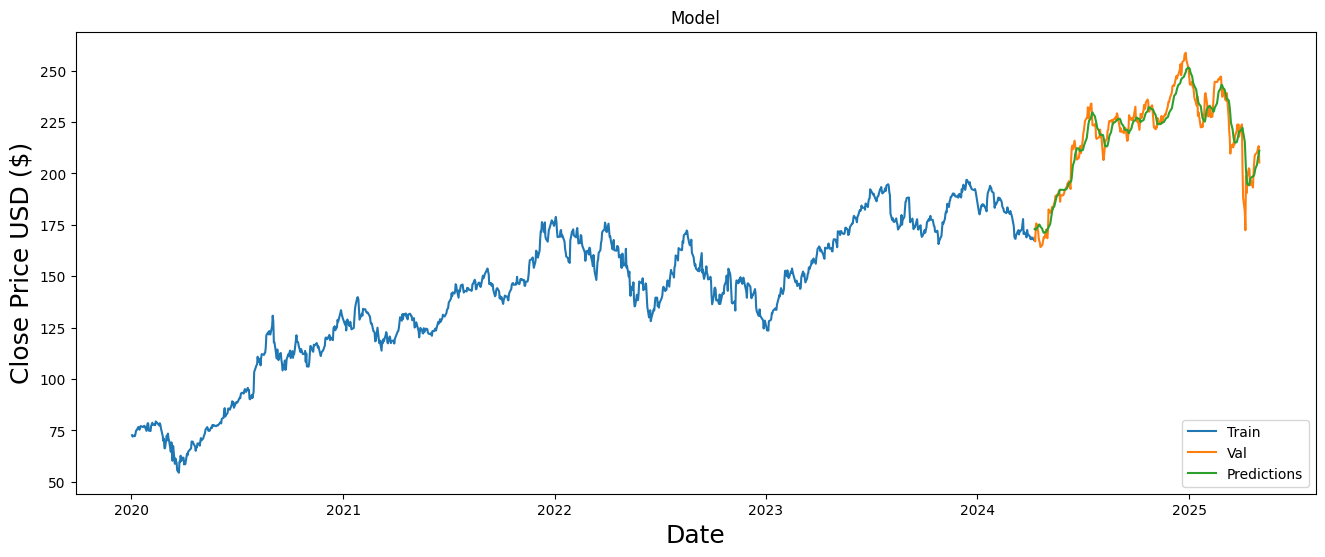

In [11]:
dates = data.index

# Convert dataset (scaled or unscaled) back to a DataFrame
dataset_df = pd.DataFrame(dataset, index=dates, columns=['Close'])

# Split into train and valid DataFrames
train = dataset_df[:training_data_len]
valid = dataset_df[training_data_len:].copy()

# Add predictions to valid set (make sure predictions is same length)
valid['Predictions'] = predictions

# Plot the results
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [12]:
valid

,Close,Predictions
Date,,
2024-04-09,168.872604,172.997253
2024-04-10,166.991486,172.847504
2024-04-11,174.217377,172.595703
2024-04-12,175.720276,173.139465
2024-04-15,171.878418,174.200363
...,...,...
2025-04-28,210.139999,204.209885
2025-04-29,211.210007,206.183060
2025-04-30,212.500000,208.000107
